# Antivirals QSAR using DeepChem for Coronaviruses

From the Chembl database we extracted all compounds with reported interaction to CHEMBL5118 and CHEMBL3927. These references correspond to replicase polyprotein 1ab and SARS coronavirus 3C-like proteinase respectively. These are the only coronavirus related targets in the ChemBL database.

We used SMILES of drugs as inputs that are transformed into a specific format for the future classification (anti-viral or non-antiviral) that uses Graph Convolutional Nets (DeepChem package). Instead of designing a featurization ourselves, the method learns one automatically from the data similar with the Convolutional Neural Networks for images.


The calculations used Google Colab GPU.

### Instalation of DeepChem with GPU on GColab

In [3]:
%tensorflow_version 1.x
!wget -c https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

TensorFlow 1.x selected.
--2020-05-19 18:50:46--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  81.12M   159MB/s    in 0.5s    

2020-05-19 18:50:47 (159 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling

### Set parameters, file names, path

Set the seed for numpy and tensorflow:

In [0]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)
import deepchem as dc

Mount the folder with all files from Google Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import os
import pandas as pd

# define the path to the dataset for training
input_data=os.path.join("/content/drive/My Drive/MyProjects/DeepChem/antivirals/datasets",'antivirals_SMILES.csv')

# define the path to new prediction data
pred_data=os.path.join("/content/drive/My Drive/MyProjects/DeepChem/antivirals/datasets",'DB_SMILES4prediction.csv')

### Transform SMILES into Convolutional Graph format

In [8]:
# define output name (Class)
tasks=['Class']

# define features
featurizer=dc.feat.ConvMolFeaturizer()

# load data and calculate the features for dataset
loader = dc.data.CSVLoader(tasks=tasks, smiles_field="smiles",featurizer=featurizer)
dataset=loader.featurize(input_data, data_dir='/content/drive/My Drive/MyProjects/DeepChem/antivirals/features_antivirals/')

# calculate the same features for new data to predict
loader2 = dc.data.CSVLoader(tasks=tasks, smiles_field="smiles",featurizer=featurizer)
dataset_pred=loader2.featurize(pred_data, data_dir='/content/drive/My Drive/MyProjects/DeepChem/antivirals/features_DBpredictions/')

Loading raw samples now.
shard_size: 8192
About to start loading CSV from /content/drive/My Drive/MyProjects/DeepChem/antivirals/datasets/antivirals_SMILES.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 1.099 s
TIMING: dataset construction took 15.207 s
Loading dataset from disk.
Loading raw samples now.
shard_size: 8192
About to start loading CSV from /content/drive/My Drive/MyProjects/DeepChem/antivirals/datasets/DB_SMILES4prediction.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 0 took 33.996 s
Loading shard 2 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
TIMING: featurizing shard 1 took 10.864 s
TIMING: dataset construction took 57.921 s
Loading dataset from disk.


In [9]:
print('Full dataset samples : {}'.format(dataset.X.shape[0]))
print('External dataset samples : {}'.format(dataset_pred.X.shape[0]))

Full dataset samples : 229
External dataset samples : 10246


In [10]:
# define a transformer for data using only training subset!
transformers = [
                dc.trans.NormalizationTransformer(transform_y=True, dataset=dataset)]

# apply transformation to all datasets including the external 
for transformer in transformers:
  dataset = transformer.transform(dataset)

for transformer in transformers:
  dataset_pred = transformer.transform(dataset_pred)

TIMING: dataset construction took 0.132 s
Loading dataset from disk.
TIMING: dataset construction took 6.399 s
Loading dataset from disk.


Define the metrics for training as AUROC:

In [0]:
# define mean AUROC metrics for the classifier
metric = dc.metrics.Metric(
    dc.metrics.roc_auc_score, np.mean, mode="classification")

# define number of internal features
n_feat = 75

# define batch size during the training
batch_size = 32

# dropout 
n_dropout = 0.05

### Test with one split and different epochs

In [65]:
from deepchem.models import GraphConvModel

# define a splitter 
splitter = dc.splits.SingletaskStratifiedSplitter() #ScaffoldSplitter

# split dataset into train, test subsets (80% - 20%)
train_dataset, test_dataset= splitter.train_test_split(dataset, 
                                                       seed=80,
                                                       frac_train=0.8, 
                                                       verbose=False)
print('Full dataset samples : {}'.format(dataset.X.shape[0]))
print('Train dataset samples : {}'.format(train_dataset.X.shape[0]))
print('Test dataset samples : {}'.format(test_dataset.X.shape[0]))

model = GraphConvModel(
    len(tasks), batch_size=batch_size, mode='classification',
    dropout=n_dropout,
    # model_dir='/content/drive/My Drive/MyProjects/DeepChem/antivirals/models/oneSplitMoreEpochs',
    random_seed=42) # same seed here!

# check the error for optimal number of epochs
num_epochs = 200

losses = []
auroc_train = []
auroc_test = []

for i in range(num_epochs):
  loss = model.fit(train_dataset, nb_epoch=1, deterministic=True)
  print("Epoch %d loss: %f" % (i, loss))
  losses.append(loss)

  # print statistics
  print("Evaluating model")
  train_scores = model.evaluate(train_dataset, [metric], transformers)
  print("Training ROC-AUC Score: %f" % train_scores["mean-roc_auc_score"])
  test_scores = model.evaluate(test_dataset, [metric], transformers)
  print("Test ROC-AUC Score: %f" % test_scores["mean-roc_auc_score"])

  auroc_train.append(train_scores["mean-roc_auc_score"])
  auroc_test.append(test_scores["mean-roc_auc_score"])

TIMING: dataset construction took 0.110 s
Loading dataset from disk.
TIMING: dataset construction took 0.068 s
Loading dataset from disk.
Full dataset samples : 229
Train dataset samples : 176
Test dataset samples : 44


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 0 loss: 0.933357
Evaluating model
computed_metrics: [0.63811666398843]
Training ROC-AUC Score: 0.638117
computed_metrics: [0.5416666666666667]
Test ROC-AUC Score: 0.541667
Epoch 1 loss: 0.598969
Evaluating model
computed_metrics: [0.6628635706251004]
Training ROC-AUC Score: 0.662864
computed_metrics: [0.5651041666666667]
Test ROC-AUC Score: 0.565104
Epoch 2 loss: 0.512048
Evaluating model
computed_metrics: [0.6739514703519203]
Training ROC-AUC Score: 0.673951
computed_metrics: [0.5833333333333334]
Test ROC-AUC Score: 0.583333
Epoch 3 loss: 0.527264
Evaluating model
computed_metrics: [0.7721356259039049]
Training ROC-AUC Score: 0.772136
computed_metrics: [0.5911458333333333]
Test ROC-AUC Score: 0.591146
Epoch 4 loss: 0.512009
Evaluating model
computed_metrics: [0.8225936043708821]
Training ROC-AUC Score: 0.822594
computed_metrics: [0.5364583333333334]
Test ROC-AUC Score: 0.536458
Epoch 5 loss: 0.485801
Evaluating model
computed_metrics: [0.8441266270287642]
Training ROC-AUC Score:

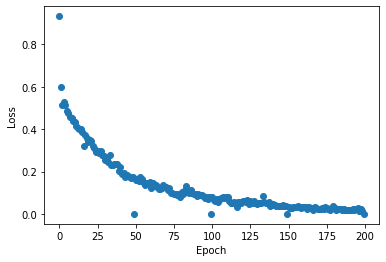

In [66]:
# plot the errors
import matplotlib.pyplot as plot

plot.ylabel("Loss")
plot.xlabel("Epoch")
x = range(num_epochs)
y = losses
plot.scatter(x, y)
plot.show()

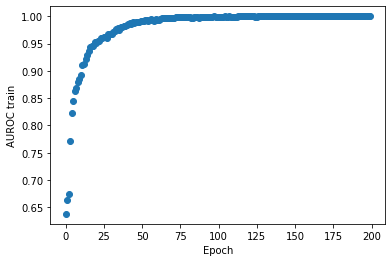

In [67]:
# plot the auroc train
import matplotlib.pyplot as plot

plot.ylabel("AUROC train")
plot.xlabel("Epoch")
x = range(num_epochs)
y = auroc_train
plot.scatter(x, y)
plot.show()

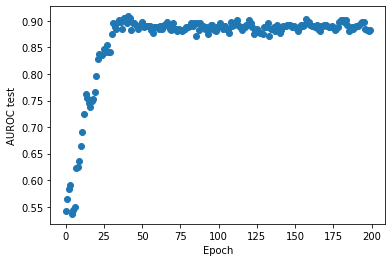

In [68]:
# plot the auroc test
import matplotlib.pyplot as plot

plot.ylabel("AUROC test")
plot.xlabel("Epoch")
x = range(num_epochs)
y = auroc_test
plot.scatter(x, y)
plot.show()

In [70]:
np.max(auroc_test)

0.9088541666666667

In [71]:
np.mean(auroc_test)

0.8634505208333334

### Classification for 10 random stratified splits

In [0]:
# define batch size during the training
batch_size = 32

# dropout 
n_dropout = 0.05

# number of epochs
n_epoch = 70

In [74]:
from deepchem.models import GraphConvModel

scores_train=[]
scores_test =[]

# for each seed for external split TRAIN-TEST
for seed_ext in [10,20,30,40,50,60,70,80,90,100]:
  print("*** External split")
  print("> ext seed =", seed_ext)

  # define a splitter 
  splitter = dc.splits.SingletaskStratifiedSplitter()

  # split dataset into train, test subsets (80% - 20%)
  train_dataset, test_dataset= splitter.train_test_split(dataset, 
                                                         seed=seed_ext,
                                                         frac_train=0.8, 
                                                         verbose=False)
  print('Full dataset samples : {}'.format(dataset.X.shape[0]))
  print('Train dataset samples : {}'.format(train_dataset.X.shape[0]))
  print('Test dataset samples : {}'.format(test_dataset.X.shape[0]))

  model = GraphConvModel(
      len(tasks), batch_size=batch_size, mode='classification',
      dropout=n_dropout,
      random_seed=42) # same seed here!
    
  # Fit model using train_data
  model.fit(train_dataset, nb_epoch=n_epoch, deterministic=True) # 5 for testing

  # evaluating the model for train-test
  train_scores = model.evaluate(train_dataset, [metric], transformers)

  scores_train.append(train_scores["mean-roc_auc_score"])
  
  # evaluating test scores
  test_scores = model.evaluate(test_dataset, [metric], transformers)
  scores_test.append(test_scores["mean-roc_auc_score"])

*** External split
> ext seed = 10
TIMING: dataset construction took 0.109 s
Loading dataset from disk.
TIMING: dataset construction took 0.064 s
Loading dataset from disk.
Full dataset samples : 229
Train dataset samples : 176
Test dataset samples : 44


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.9983723958333334]
computed_metrics: [0.8535980148883375]
*** External split
> ext seed = 20
TIMING: dataset construction took 0.114 s
Loading dataset from disk.
TIMING: dataset construction took 0.062 s
Loading dataset from disk.
Full dataset samples : 229
Train dataset samples : 176
Test dataset samples : 44


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.9986979166666666]
computed_metrics: [0.7121588089330024]
*** External split
> ext seed = 30
TIMING: dataset construction took 0.113 s
Loading dataset from disk.
TIMING: dataset construction took 0.061 s
Loading dataset from disk.
Full dataset samples : 229
Train dataset samples : 176
Test dataset samples : 44


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.9996786116021211]
computed_metrics: [0.8385416666666667]
*** External split
> ext seed = 40
TIMING: dataset construction took 0.116 s
Loading dataset from disk.
TIMING: dataset construction took 0.063 s
Loading dataset from disk.
Full dataset samples : 229
Train dataset samples : 176
Test dataset samples : 44


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.9972681986180298]
computed_metrics: [0.8177083333333333]
*** External split
> ext seed = 50
TIMING: dataset construction took 0.114 s
Loading dataset from disk.
TIMING: dataset construction took 0.060 s
Loading dataset from disk.
Full dataset samples : 229
Train dataset samples : 176
Test dataset samples : 44


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [1.0]
computed_metrics: [0.71875]
*** External split
> ext seed = 60
TIMING: dataset construction took 0.113 s
Loading dataset from disk.
TIMING: dataset construction took 0.060 s
Loading dataset from disk.
Full dataset samples : 229
Train dataset samples : 176
Test dataset samples : 44


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.999196529005303]
computed_metrics: [0.7265625]
*** External split
> ext seed = 70
TIMING: dataset construction took 0.111 s
Loading dataset from disk.
TIMING: dataset construction took 0.062 s
Loading dataset from disk.
Full dataset samples : 229
Train dataset samples : 176
Test dataset samples : 44


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.9967861160212117]
computed_metrics: [0.8359375]
*** External split
> ext seed = 80
TIMING: dataset construction took 0.114 s
Loading dataset from disk.
TIMING: dataset construction took 0.059 s
Loading dataset from disk.
Full dataset samples : 229
Train dataset samples : 176
Test dataset samples : 44


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.9972681986180298]
computed_metrics: [0.90625]
*** External split
> ext seed = 90
TIMING: dataset construction took 0.125 s
Loading dataset from disk.
TIMING: dataset construction took 0.058 s
Loading dataset from disk.
Full dataset samples : 229
Train dataset samples : 176
Test dataset samples : 44


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [1.0]
computed_metrics: [0.7421875]
*** External split
> ext seed = 100
TIMING: dataset construction took 0.110 s
Loading dataset from disk.
TIMING: dataset construction took 0.062 s
Loading dataset from disk.
Full dataset samples : 229
Train dataset samples : 176
Test dataset samples : 44


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.9991965290053029]
computed_metrics: [0.6848958333333334]


In [75]:
scores_train

[0.9983723958333334,
 0.9986979166666666,
 0.9996786116021211,
 0.9972681986180298,
 1.0,
 0.999196529005303,
 0.9967861160212117,
 0.9972681986180298,
 1.0,
 0.9991965290053029]

In [76]:
scores_test

[0.8535980148883375,
 0.7121588089330024,
 0.8385416666666667,
 0.8177083333333333,
 0.71875,
 0.7265625,
 0.8359375,
 0.90625,
 0.7421875,
 0.6848958333333334]

In [77]:
np.mean(scores_train), np.mean(scores_test)

(0.9986464495369999, 0.7836590157154674)

Test scores:

{'boxes': [<matplotlib.lines.Line2D at 0x7fd4a0fcbac8>],
 'caps': [<matplotlib.lines.Line2D at 0x7fd4a387a9e8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fd4a387a8d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fd4a387abe0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fd4a0fcb9b0>,
  <matplotlib.lines.Line2D at 0x7fd4a10509e8>]}

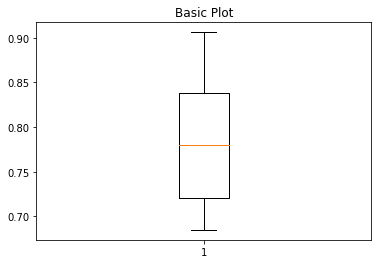

In [78]:
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(scores_test)

### Get the final model to make prediction

In [0]:
# define batch size during the training
batch_size = 32

# dropout 
n_dropout = 0.05

# number of epochs
n_epoch = 70

In [53]:
# define a splitter 
splitter = dc.splits.SingletaskStratifiedSplitter() #ScaffoldSplitter

# split dataset into train, test subsets (80% - 20%)
train_dataset, test_dataset= splitter.train_test_split(dataset, 
                                                      seed=80,
                                                      frac_train=0.8, 
                                                      verbose=False)
print('Full dataset samples : {}'.format(dataset.X.shape[0]))
print('Train dataset samples : {}'.format(train_dataset.X.shape[0]))
print('Test dataset samples : {}'.format(test_dataset.X.shape[0]))

TIMING: dataset construction took 0.113 s
Loading dataset from disk.
TIMING: dataset construction took 0.061 s
Loading dataset from disk.
Full dataset samples : 229
Train dataset samples : 176
Test dataset samples : 44


In [54]:
# define the model
from deepchem.models import GraphConvModel

model = GraphConvModel(
    len(tasks), batch_size=batch_size, mode='classification',
    dropout=n_dropout,
    model_dir='/content/drive/My Drive/MyProjects/DeepChem/antivirals/models_antivirals/', # output folder for models!
    random_seed=42) # same seed here!

In [55]:
# Fit trained model
model.fit(train_dataset, nb_epoch=n_epoch, deterministic=True)

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0.09649734534323215

In [56]:
# print statistics
print("Evaluating model")
train_scores = model.evaluate(train_dataset, [metric], transformers)
print("Training ROC-AUC Score: %f" % train_scores["mean-roc_auc_score"])
test_scores = model.evaluate(test_dataset, [metric], transformers)
print("Test ROC-AUC Score: %f" % test_scores["mean-roc_auc_score"])

Evaluating model
computed_metrics: [0.9979109754137876]
Training ROC-AUC Score: 0.997911
computed_metrics: [0.9140625]
Test ROC-AUC Score: 0.914062


In [22]:
test_scores

{'mean-roc_auc_score': 0.9192708333333333}

### Make prediction with this model

In [0]:
predictions = model.predict(dataset_pred)

In [58]:
import pandas as pd

df = pd.read_csv(pred_data)
df

,chembl_id,smiles,Class
0,DB12480,[H]OC(=O)[C@]12CC[C@@]([H])(C(C)=C)[C@]1([H])[...,-1
1,DB01337,[H][C@@]12C[C@@H]([C@H](OC(C)=O)[C@@]1(C)CC[C@...,-1
2,DB12025,CC(C)[C@]12O[C@H]1[C@@H]1O[C@]11[C@]3(O[C@H]3C...,-1
3,DB14037,[H][C@]12CC=C3[C@]4([H])[C@@H](C)[C@H](C)CC[C@...,-1
4,DB14054,[H][C@@]12CC[C@]3(C)[C@]([H])(CC=C4[C@]5([H])[...,-1
...,...,...,...
10249,DB14909,CCCCCCCCCCCCCCCC(=O)NCC(O)COP(S)(=O)OCC1OC(CC1...,-1
10250,DB05528,[H]C1(CC([H])(OP(O)(=S)OCC2([H])OC([H])(CC2([H...,-1
10251,DB06094,COCCOC1C(O)C(COP(O)(=S)OC2C(COP(O)(=S)OC3C(COP...,-1
10252,DB04998,[H][C@]1(O)C[C@@]([H])(O[C@]1([H])COP(O)(=O)O[...,-1


In [59]:
# create a dataframe with the predictions
df_preds = pd.DataFrame (columns = ['smiles','ProbClass1'])
df_preds['smiles'] = list(dataset_pred.ids)
df_preds['ProbClass1'] = list(predictions[:,0,1]) # second column = % class 1
df_preds

,smiles,ProbClass1
0,[H]OC(=O)[C@]12CC[C@@]([H])(C(C)=C)[C@]1([H])[...,0.021727
1,[H][C@@]12C[C@@H]([C@H](OC(C)=O)[C@@]1(C)CC[C@...,0.011289
2,CC(C)[C@]12O[C@H]1[C@@H]1O[C@]11[C@]3(O[C@H]3C...,0.807539
3,[H][C@]12CC=C3[C@]4([H])[C@@H](C)[C@H](C)CC[C@...,0.072777
4,[H][C@@]12CC[C@]3(C)[C@]([H])(CC=C4[C@]5([H])[...,0.075367
...,...,...
10241,CCCCCCCCCCCCCCCC(=O)NCC(O)COP(S)(=O)OCC1OC(CC1...,0.419311
10242,[H]C1(CC([H])(OP(O)(=S)OCC2([H])OC([H])(CC2([H...,0.108860
10243,COCCOC1C(O)C(COP(O)(=S)OC2C(COP(O)(=S)OC3C(COP...,0.199987
10244,[H][C@]1(O)C[C@@]([H])(O[C@]1([H])COP(O)(=O)O[...,0.836937


In [60]:
merged_inner = pd.merge(left=df, right=df_preds, left_on='smiles', right_on='smiles')
merged_inner

,chembl_id,smiles,Class,ProbClass1
0,DB12480,[H]OC(=O)[C@]12CC[C@@]([H])(C(C)=C)[C@]1([H])[...,-1,0.021727
1,DB01337,[H][C@@]12C[C@@H]([C@H](OC(C)=O)[C@@]1(C)CC[C@...,-1,0.011289
2,DB12025,CC(C)[C@]12O[C@H]1[C@@H]1O[C@]11[C@]3(O[C@H]3C...,-1,0.807539
3,DB14037,[H][C@]12CC=C3[C@]4([H])[C@@H](C)[C@H](C)CC[C@...,-1,0.072777
4,DB14054,[H][C@@]12CC[C@]3(C)[C@]([H])(CC=C4[C@]5([H])[...,-1,0.075367
...,...,...,...,...
10241,DB14909,CCCCCCCCCCCCCCCC(=O)NCC(O)COP(S)(=O)OCC1OC(CC1...,-1,0.419311
10242,DB05528,[H]C1(CC([H])(OP(O)(=S)OCC2([H])OC([H])(CC2([H...,-1,0.108860
10243,DB06094,COCCOC1C(O)C(COP(O)(=S)OC2C(COP(O)(=S)OC3C(COP...,-1,0.199987
10244,DB04998,[H][C@]1(O)C[C@@]([H])(O[C@]1([H])COP(O)(=O)O[...,-1,0.836937


In [61]:
merged_inner = merged_inner.sort_values(by='ProbClass1', ascending=False)
merged_inner

,chembl_id,smiles,Class,ProbClass1
10073,DB08949,O=C(O[C@H]1[C@H](OC(=O)C2=CC=CN=C2)[C@@H](OC(=...,-1,0.998900
3013,DB12178,CC(C)CN(C[C@@H](O)[C@H](CC1=CC=CC=C1)NC(=O)[C@...,-1,0.998016
260,DB11669,CC(C)C[C@H](NC(=O)OC(C)(C)C)[C@@H](O)C(=O)O[C@...,-1,0.997692
9648,DB13441,O=C(OCC(COC(=O)C1=CN=CC=C1)(COC(=O)C1=CN=CC=C1...,-1,0.996963
3560,DB06573,CNC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](...,-1,0.995598
...,...,...,...,...
6386,DB01171,ClC1=CC=C(C=C1)C(=O)NCCN1CCOCC1,-1,0.000029
8576,DB04020,OC1=CC=C(CCNC2=NC(SCCCC3=CC=C(Cl)C=C3)=NC(=N2)...,-1,0.000029
7944,DB03742,[H][C@]1(OC2=C(S[C@]1([H])C1=CC=C(O)C=C1)C=C(O...,-1,0.000026
3318,DB07567,[H][C@@]1(C)C2=CC(O)=CC=C2O[C@@]([H])(C2=CC=C(...,-1,0.000022


In [0]:
# save the predictions on disk
merged_inner.to_csv('/content/drive/My Drive/MyProjects/DeepChem/antivirals/antivirals_predictions.csv', index=False)